In [1]:
import celltypist
from celltypist import models
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce

In [2]:
def read_mat(h5_con):
    mat = scs.csc_matrix(
        (h5_con['matrix']['data'][:], # Count values
         h5_con['matrix']['indices'][:], # Row indices
         h5_con['matrix']['indptr'][:]), # Pointers for column positions
        shape = tuple(h5_con['matrix']['shape'][:]) # Matrix dimensions
    )
    return mat

# define a function to obeservation (i.e. metadata)

def read_obs(h5con):
    bc = h5con['matrix']['barcodes'][:]
    bc = [x.decode('UTF-8') for x in bc]

    # Initialized the DataFrame with cell barcodes
    obs_df = pd.DataFrame({ 'barcodes' : bc })

    # Get the list of available metadata columns
    obs_columns = h5con['matrix']['observations'].keys()

    # For each column
    for col in obs_columns:
        # Read the values
        values = h5con['matrix']['observations'][col][:]
        # Check for byte storage
        if(isinstance(values[0], (bytes, bytearray))):
            # Decode byte strings
            values = [x.decode('UTF-8') for x in values]
        # Add column to the DataFrame
        obs_df[col] = values
    
    return obs_df
# define a function to construct anndata object from a h5 file
def read_h5_anndata(h5_file):
    h5_con = h5py.File(h5_file, mode = 'r')
    # extract the expression matrix
    mat = read_mat(h5_con)
    # extract gene names
    genes = h5_con['matrix']['features']['name'][:]
    genes = [x.decode('UTF-8') for x in genes]
    # extract metadata
    obs_df = read_obs(h5_con)
    # construct anndata
    adata = anndata.AnnData(mat.T,
                             obs = obs_df)
    # make sure the gene names aligned
    adata.var_names = genes

    adata.var_names_make_unique()
    return adata
def get_last_pattern(inputstr):
    pattern = r"[^/]+(?=$)"
    match = re.search(pattern, inputstr)
    if match:
        return match.group(0)
    else:
        return ""
    

In [3]:
meta_data=pd.read_csv("/home//jupyter/hise_meta_data_2023-11-02.csv")

In [4]:
adata=sc.read_h5ad('adata_all_raw.h5ad')

108

In [8]:
matching_strings = []

# Iterate through the list and find matching strings
for string in  list(meta_data['file.name.downloaded']):
    match = re.search(r'PB\d{5}-\d+', string)
    if match:
        matching_strings.append(match.group())


In [9]:
meta_data['pbmc_sample_id']=matching_strings

In [10]:
CMV=pd.read_csv('CMV_20220718_UPBR.csv')
BMI=pd.read_csv('BR-BR-Clinical-BMI.csv')
CMV=CMV.merge(BMI, on='subject.subjectGuid', how='left')
meta_data=meta_data.merge(CMV, on='subject.subjectGuid', how='left')

df=adata.obs.merge(meta_data[['pbmc_sample_id', 'subject.biologicalSex',
        'subject.ethnicity', 'subject.partnerCode',
       'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 
           'sample.visitDetails', 'subject.birthYear','CMV.IgG.Serology.Result.Interpretation', 'BMI']], on='pbmc_sample_id', how='left')

In [11]:
col_list=['subject.biologicalSex','subject.ethnicity', 'subject.partnerCode',
          'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 
          'sample.visitDetails', 'subject.birthYear','CMV.IgG.Serology.Result.Interpretation', 
          'BMI']

In [12]:
def process_sample(sample_id):
    seurat_labels = pd.read_csv(f'Labels_20231102/{sample_id}.csv')
    seurat_labels = seurat_labels[['barcodes', 'predicted.celltype.l1.score', 'predicted.celltype.l1',
                                   'predicted.celltype.l2.score', 'predicted.celltype.l2',
                                   'predicted.celltype.l3.score', 'predicted.celltype.l3',
                                   'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5']]
    celltypeist_labels = pd.read_csv(f'Labels_Celltypist/{sample_id}_Low.csv')
    celltypeist_labels = celltypeist_labels[['barcodes', 'predicted_labels', 'majority_voting']]
    celltypeist_labels.columns = ['barcodes', 'predicted_labels_celltypist', 'majority_voting_celltypist']
    
    merged_df = pd.merge(seurat_labels, celltypeist_labels, on='barcodes', how='left')
    
    return merged_df

In [13]:
from concurrent.futures import ThreadPoolExecutor


dfs = []  # To store the resultant dataframes
with ThreadPoolExecutor(max_workers=60) as executor:
    dfs = list(executor.map(process_sample, meta_data['pbmc_sample_id']))

# Combining all dataframes in the list `dfs`
final_df = pd.concat(dfs, ignore_index=True)

In [14]:
df=df.merge(final_df, on='barcodes', how='left')

In [15]:
doublet_scores=pd.read_parquet('doublet_score.parquet')
df=df.merge(doublet_scores, on='barcodes', how='left')

In [16]:
col_list=['subject.biologicalSex','subject.ethnicity', 'subject.partnerCode',
          'subject.race', 'subject.subjectGuid', 
          'cohort.cohortGuid', 'sample.visitName', 
          'sample.visitDetails', 'subject.birthYear',
          'CMV.IgG.Serology.Result.Interpretation', 'BMI', 
          'predicted.celltype.l1.score', 'predicted.celltype.l1',
          'predicted.celltype.l2.score', 'predicted.celltype.l2',
          'predicted.celltype.l3.score', 'predicted.celltype.l3',
          'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5',
          'predicted_labels_celltypist', 'majority_voting_celltypist',
          'predicted_doublet','doublet_score']

In [17]:
for i in col_list:
    adata.obs[i]=list(df[i])

In [18]:
adata=adata[adata.obs['predicted_doublet']==False]

In [20]:
adata.obs['pbmc_sample_id'].nunique()

108

In [23]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)

... storing 'subject.biologicalSex' as categorical
... storing 'subject.ethnicity' as categorical
... storing 'subject.partnerCode' as categorical
... storing 'subject.race' as categorical
... storing 'subject.subjectGuid' as categorical
... storing 'cohort.cohortGuid' as categorical
... storing 'sample.visitName' as categorical
... storing 'sample.visitDetails' as categorical
... storing 'CMV.IgG.Serology.Result.Interpretation' as categorical
... storing 'BMI' as categorical
... storing 'predicted.celltype.l1' as categorical
... storing 'predicted.celltype.l2' as categorical
... storing 'predicted.celltype.l3' as categorical
... storing 'predicted.celltype.l2.5' as categorical
... storing 'predicted_labels_celltypist' as categorical
... storing 'majority_voting_celltypist' as categorical


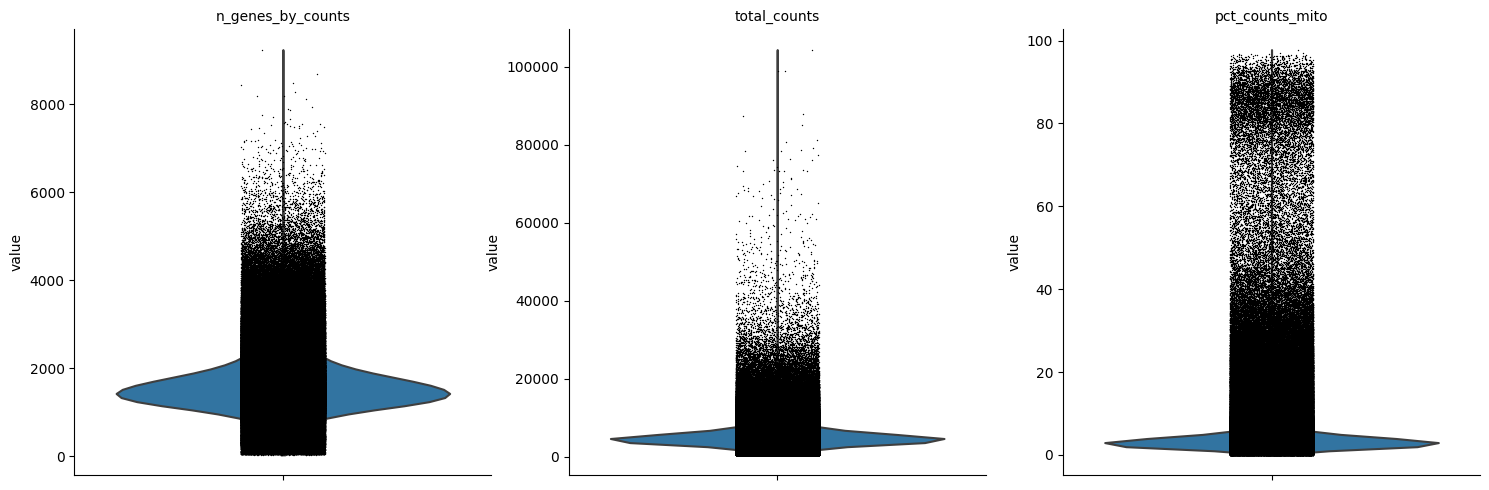

In [24]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito'],
              multi_panel=True)

In [25]:
adata=adata[(adata.obs["pct_counts_mito"] <10) & (adata.obs["n_genes"] <5000) &(adata.obs["n_genes"] >200) ]

In [26]:
adata.raw=adata

In [29]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [30]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]]

In [31]:
sc.pp.scale(adata)

In [32]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sce.pp.harmony_integrate(adata, 'cohort.cohortGuid',max_iter_harmony = 20)

2023-11-03 02:27:49,927 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2023-11-03 02:39:38,284 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2023-11-03 02:40:01,457 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2023-11-03 02:58:55,019 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2023-11-03 03:14:26,168 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2023-11-03 03:37:20,683 - harmonypy - INFO - Iteration 4 of 20
Iteration 4 of 20
2023-11-03 03:57:57,338 - harmonypy - INFO - Iteration 5 of 20
Iteration 5 of 20


In [ ]:
sc.pp.neighbors(adata, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata)

In [ ]:
adata.write_h5ad('adata_processed_before_leiden.h5ad')

In [ ]:
sc.tl.leiden(adata)

In [ ]:
adata.write_h5ad('adata_processed.h5ad')

In [ ]:
adata

AnnData object with n_obs × n_vars = 1950750 × 1235
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top

In [3]:
adata=sc.read_h5ad('adata_processed.h5ad')

<Axes: title={'center': 'predicted.celltype.l2.5'}, xlabel='UMAP1', ylabel='UMAP2'>

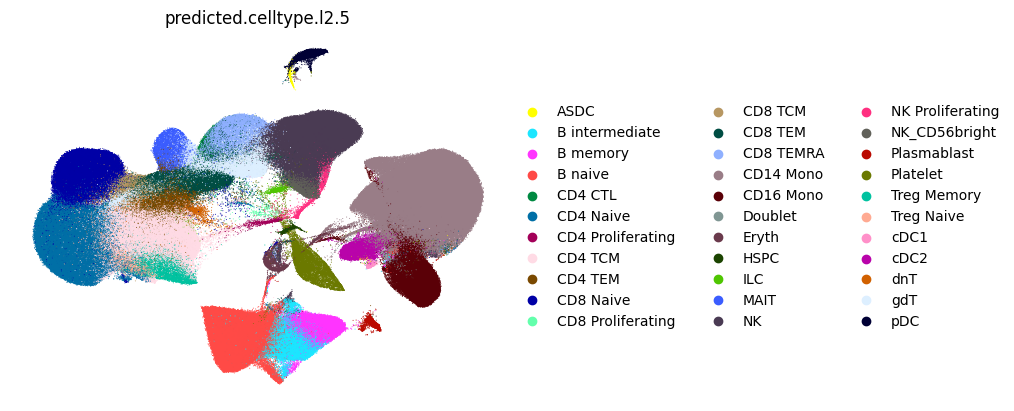

In [4]:
sc.pl.umap(adata, color=['predicted.celltype.l2.5'], size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'predicted_labels_celltypist'}, xlabel='UMAP1', ylabel='UMAP2'>

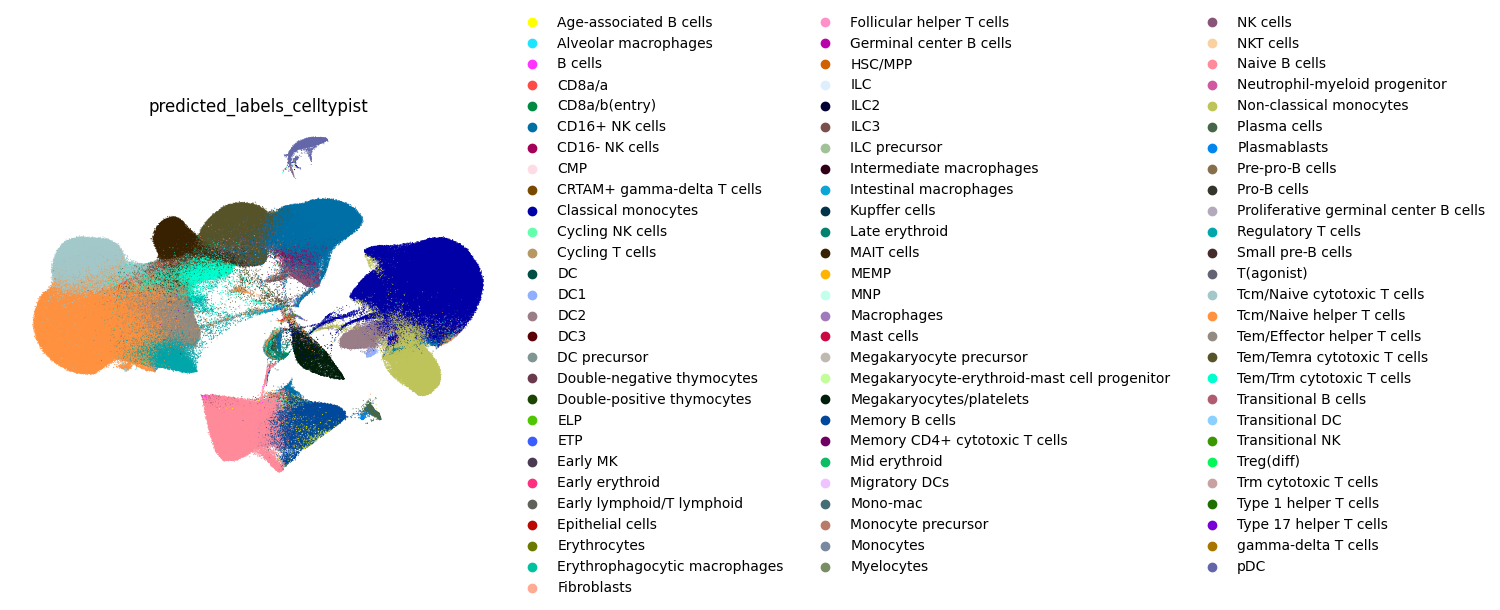

In [5]:
sc.pl.umap(adata, color=['predicted_labels_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'majority_voting_celltypist'}, xlabel='UMAP1', ylabel='UMAP2'>

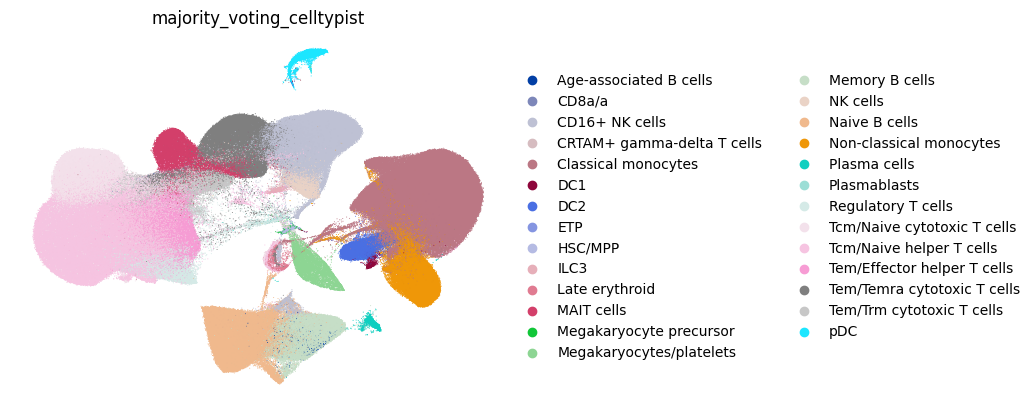

In [6]:
sc.pl.umap(adata, color=['majority_voting_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

In [ ]:
sc.tl.leiden(adata)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [11]:
adata

AnnData object with n_obs × n_vars = 1889960 × 1292
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_gen

<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

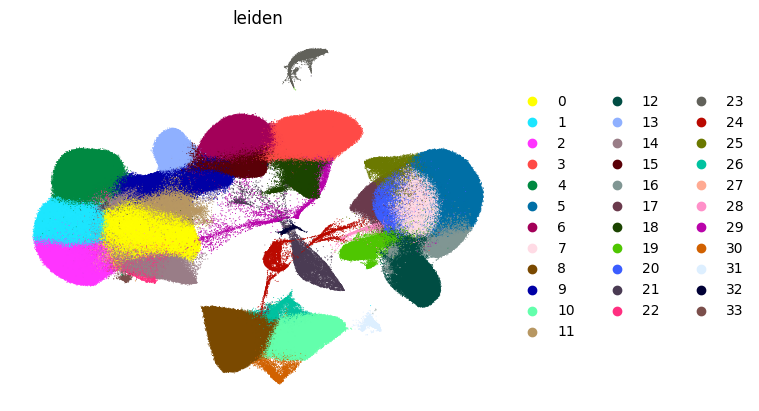

In [12]:
sc.pl.umap(adata, color=['leiden'], size=2,show=False,ncols=1 ,frameon=False)